In [96]:
import pandas  as pd
import os
import numpy as np
from tqdm import tqdm
%matplotlib inline

In [86]:
inVcfDir='/data/cellardata/users/btsui/dbsnp/Homo_sapiens/All_20170710.f1_byte2_not_00.vcf.gz' 
vcfDf=pd.read_csv(inVcfDir,sep='\t',header=None)
vcfDf.columns=['Chr','Pos','RsId','RefBase','AltBase','','','Annot']
vcfDf['Chr']=vcfDf['Chr'].astype(str)

/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [87]:
vcfDf['VP_Int']=vcfDf['Annot'].str.extract('VP=(0x\w+)',expand=False).apply(lambda Str:int(Str,16))

### extract sites with alternative alleles

In [88]:
#from right to left
nth_bit=6
vcfDf['somatic']=(vcfDf['VP_Int']%(2**(nth_bit-1))).astype(bool).values

In [89]:
myG=['Chr','Pos']
refS=vcfDf.drop_duplicates(myG).set_index(myG)['RefBase']

In [90]:
vcfDf['specificSNP']=vcfDf['AltBase'].str.contains('^[ACGT]$')

In [91]:
#check if braf is located within germline
myG=['Run_db','Run_digits',u'Chr', u'Pos',u'base']
#vcfDf.head()

In [92]:
vcfDf.head()

,Chr,Pos,RsId,RefBase,AltBase,,,Annot,VP_Int,somatic,specificSNP
0,1,14727,rs1045587,G,A,.,.,RS=1045587;RSPOS=14727;RV;dbSNPBuildID=117;SSR...,1547614017554423799187767552,False,True
1,1,630825,rs9783068,T,C,.,.,RS=9783068;RSPOS=630825;dbSNPBuildID=119;SSR=1...,1547613980660935651768664384,False,True
2,1,630833,rs9701099,C,T,.,.,RS=9701099;RSPOS=630833;dbSNPBuildID=119;SSR=1...,1547613980660935651768664384,False,True
3,1,817186,rs3094315,G,A,.,.,RS=3094315;RSPOS=817186;RV;dbSNPBuildID=103;SS...,1548822906480573393185800449,True,True
4,1,833068,rs12562034,G,A,.,.,RS=12562034;RSPOS=833068;dbSNPBuildID=120;SSR=...,1548823017161040034332147968,False,True


In [93]:
tmp_dir='/nrnb/users/btsui/Data/all_seq/tmp/'

In [94]:
inFnameS=pd.Series(os.listdir(tmp_dir)).sample(n=10)

In [97]:
#inFname=inFnameS.iloc[0]
#cell line
myL=[]
for inFname in tqdm(inFnameS):
    tmpDf=pd.read_pickle(tmp_dir+inFname)
    tmpDf2=tmpDf.reset_index().drop_duplicates()

    tmpDf2['base']=tmpDf2.base.astype(str)
    myL.append(tmpDf2)

100%|██████████| 10/10 [00:52<00:00,  5.28s/it]


In [98]:
tmpDf2=pd.concat(myL,axis=0)

In [61]:


#tmpDf2.head().dtypes

myI=tmpDf2.set_index(['Chr','Pos','base']).index
refI=vcfDf.set_index(['Chr','Pos','RefBase']).index
m_inRef=myI.isin(refI)


In [62]:
g_l=['Run_db','Run_digits','Chr','Pos']

In [63]:
baseQualityThreshold=30
m_baseQual=tmpDf2['AverageBaseQuality']>=baseQualityThreshold

In [64]:
#tmpDf2_sub.head()

In [65]:
tmpDf2_sub=tmpDf2[m_inRef&m_baseQual]
refAlleleS=tmpDf2_sub.groupby(g_l)['ReadDepth'].first()

In [66]:
#vcfDf.Chr=='1'

In [67]:
#tmpDf2_sub.head()

In [68]:
altAlleleS=tmpDf2[(~m_inRef)&m_baseQual].groupby(g_l)['ReadDepth'].sum()

In [ ]:
%time allelic_df=pd.DataFrame({'ref_rd':refAlleleS,'alt_rd':altAlleleS})

In [ ]:
#allelic_df

In [ ]:
allelic_df.fillna(0,inplace=True)

In [ ]:
allelic_df['alt_fraction']=allelic_df['alt_rd']/allelic_df.sum(axis=1)

In [ ]:
tmpDf3=allelic_df.reset_index().set_index(['Chr','Pos'])

In [ ]:
#allelic_df.head()

In [ ]:
somaticI=vcfDf[vcfDf['somatic']&vcfDf['specificSNP']].set_index(['Chr','Pos']).index
germline_I=vcfDf[(~vcfDf['somatic'])&vcfDf['specificSNP']].set_index(['Chr','Pos']).index

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
m_allelic_f=tmpDf3['alt_fraction']>0.1

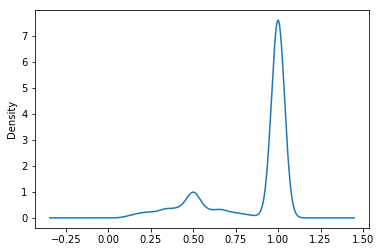

In [84]:
fig,ax=plt.subplots()
tmpDf4=tmpDf3[tmpDf3.index.isin(somaticI)&m_allelic_f]
tmpDf4['alt_fraction'].sample(n=10000).plot(kind='KDE',ax=ax,label='Known somatic sites')

In [ ]:
%time tmpDf3[tmpDf3.index.isin(germline_I)&m_allelic_f][\
    'alt_fraction'].sample(n=10000).plot(kind='KDE',ax=ax,label='germline')

In [ ]:
fig.legend()

In [ ]:
ax.set_ylabel('Density of variants')
ax.set_xlabel('Allelic frequency')

In [ ]:
fig

In [ ]:
rdS=allelic_df[['ref_rd','alt_rd']].sum(axis=1)

In [ ]:
allelic_df_filtered=allelic_df[rdS>=5]

In [ ]:
allelic_df_filtered.groupby(level=0).first()

In [ ]:
tmpDf10=allelic_df_filtered.reset_index()

In [ ]:
import seaborn as sns

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
#allelic_df_filtered

In [ ]:
myLabel='Known germline \nmutations'
#myLabel='Known somatic \nmutations'
fig,ax=plt.subplots()

germ_alt_S=allelic_df_filtered.loc[myLabel]['alt_fraction']#.hist()
m=(germ_alt_S>0)&(germ_alt_S<1)
germ_alt_S.hist(alpha=0.3,ax=ax,label=myLabel,normed=True)

myLabel='Known somatic \nmutations'
germ_alt_S=allelic_df_filtered.loc[myLabel]['alt_fraction']#.hist()
print (len(germ_alt_S))
m=(germ_alt_S>0)&(germ_alt_S<1)
germ_alt_S.hist(alpha=0.3,ax=ax,label=myLabel,normed=True)
ax.legend()


In [ ]:
allelic_df_filtered

In [ ]:
allelic_df_filtered.loc['Known somatic \nmutations']['alt_fraction'].hist()

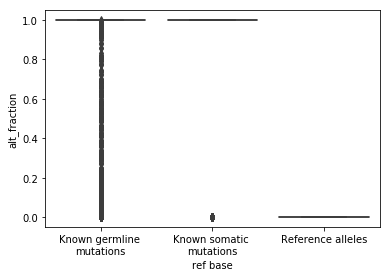

In [39]:
sns.boxplot(data=tmpDf10,x='ref base',y='alt_fraction')


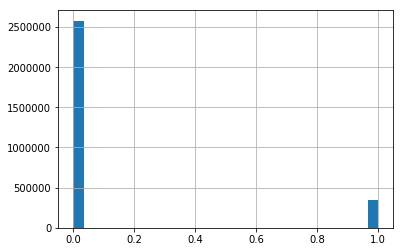

In [40]:
allelic_df_filtered['alt_fraction'].hist(bins=30)

In [24]:
%time tmpDf=tmpDf2.drop_duplicates(['Run_db','Run_digits','base']).set_index(['Run_db','Run_digits','base','ref base'])['ReadDepth'].unstack()

KeyError: 'ref_base'

In [23]:
tmpDf

base                 A     C     G     T
Run_db Run_digits                       
ERR    6279          3    14     1     8
       240801        1     5     1     4
       251422        2     9    20     9
       1492661       2     6    32     1
       1501410       1    17     1    22
       1511255       1     1     1     1
       1511378      83    10     5    11
SRR    15928         1    23     5    19
       34563         1    26     2    37
       37650         1    65     2    78
       54633         1     3     1     1
       69079         1     6     1     3
       393296        1     1     8     2
       502449        1    64     1    66
       502478        1     1     2     1
       536268        2     7     2     7
       536695        5     7     1     1
       582517        1    16     1    18
       583455        1     8     1     1
       583797        1     9     1     9
       584786        1    15     1    14
       589235        1     1     1     1
       596584        5     1    13     3
       596741        3     2    16     4
       791715        1     5     1     1
       805746       20  1422    93     1
       1002465       2     2     1    29
       1004392       1     2     1    82
       1012951       2     1    32   576
       1033161       6   110     7   120
...                ...   ...   ...   ...
       3952968       8    13    12    15
       4026436       6    99    23   100
       4049165       1     1     2     1
       4188509      12   864    70   779
       4216687       1    34     7    42
       4251138       4    13     5    13
       4270617      64     1   278  1215
       4289715     147     2  1214     5
       4422171      47     1    99  2508
       5048124       1     3     9  4298
       5112002       3   100    17    95
       5124476     241     1  1015     1
       5245302       2     2   110  1193
       5258688       1     1     1     1
       5290339       1   351    11   368
       5340434       1   355     1   345
       5421876       2    34     3    36
       5442236       6     2    67     3
       5577629       1     8    59     7
       5577693       7     4     3  1970
       5677403      54     3     6     6
       5765950       2  1254     2  1576
       5980600       1  1987    21     1
       5981899       7   261     5   217
       5983315       1     2     2     2
       6003205       1     1     1     1
       6024183       1     1     1     1
       6028304       1     1     1     1
       6028450       1     1     2     1
       6188774       8   247    73   225

[100 rows x 4 columns]

In [ ]:
#rs78378222 and rs1042522 

In [45]:
#inFname=inFnameS.iloc[1]
def inF(inFname):
    tmpDf=pd.read_pickle(tmp_dir+inFname)

    tmpDf2=tmpDf.reset_index().drop_duplicates()



    #tmpDf2.head().dtypes

    myI=tmpDf2.set_index(['Chr','Pos','base']).index

    m_inRef=myI.isin(refI)
    m_somatic=myI.isin(somaticI)
    m_germline=myI.isin(germline_I)
    tmpDf2.loc[m_inRef,'ref base']='Reference alleles'
    tmpDf2.loc[m_somatic,'ref base']='Known somatic \nmutations'
    tmpDf2.loc[m_germline,'ref base']='Known germline \nmutations'
    #tmpDf2['ref base'].fillna('Known germline \nmutations',inplace=True)

    tmpDf2['pass rd']=tmpDf2['ReadDepth']>=2

    tmpS=tmpDf2.groupby(['ref base','base','Run_db','Run_digits'])[varToPlot].sum()
    return tmpS


In [46]:
from multiprocessing import Pool

In [47]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
with Pool(48) as p:
    tmpSL=list(tqdm(p.imap(inF,inFnameS.values),
                   total=len(inFnameS)))

  8%|▊         | 213/2533 [07:24<1:20:41,  2.09s/it]

In [ ]:
mergedS=np.log10(pd.concat(tmpSL,axis=0)+1)

In [ ]:
#%matplotlib inline
plt.rcParams['pdf.fonttype'] = 42


In [ ]:
fig,ax=plt.subplots(figsize=(7,3))
ax=sns.violinplot(data=mergedS.reset_index(),
               x='ref base',y=varToPlot,ax=ax)
#ax.set_xticklabels()
#at least 2 reads
#each dot is a variant
ax.set_ylabel('log10 ( # of sequencing runs in SRA with support for variants)' )
#ax.set_xlabel()
fig.savefig('./Figures/variant_suppport_for_each_sequencing_run.pdf')
fig.savefig('./Figures/variant_suppport_for_each_sequencing_run.png',dpi=300)

In [2]:
#fig.savefig('../Results/')

In [258]:
#ax=mergedS[False].hist()

In [60]:
### make sure the data read in will have all the results
inFname=inFnameS.iloc[1]

tmpDf=pd.read_pickle(tmp_dir+inFname)

tmpDf2=tmpDf.reset_index().drop_duplicates()



#tmpDf2.head().dtypes

myI=tmpDf2.set_index(['Chr','Pos','base']).index

m_inRef=myI.isin(refI)

tmpDf2.loc[m_inRef,'ref base']=True

tmpDf2['ref base'].fillna(False,inplace=True)

tmpDf2['pass rd']=tmpDf2['ReadDepth']>=2

tmpS=tmpDf2.groupby(['ref base','base','Run_db','Run_digits'])['pass rd'].sum()

In [1]:
#tmpS

In [161]:
import matplotlib.pyplot as plt

/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


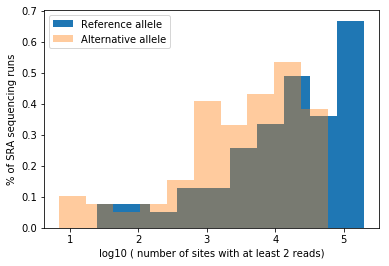

In [165]:
fig,ax=plt.subplots()
g=tmpDf2[tmpDf2['ref base']].groupby(['base','Run_db','Run_digits'])['pass rd']
countS1=np.log10(g.sum())
countS1.hist(normed=True,ax=ax,label='Reference allele')

g=tmpDf2[~tmpDf2['ref base']].groupby(['Run_db','Run_digits'])['pass rd']
countS2=np.log10(g.sum())
countS2.hist(normed=True,ax=ax,alpha=0.4,label='Alternative allele')
#'log10 ( number of sites with at least 2 reads)' , '% of SRA sequencing runs'
ax.set_ylabel('% of SRA sequencing runs')
ax.legend()
ax.set_xlabel('log10 ( number of sites with at least 2 reads)')
ax.grid(False)

In [163]:
from scipy import stats

In [ ]:
stats.wilcoxon(countS1,countS2)

In [ ]:
type(myI),

In [42]:
m_inRef.mean()

0.7398492072866819

In [ ]:
tmpDf=pd.read_pickle(tmp_dir+inFnameS.iloc[0])

In [150]:
tmpDf

features                            ReadDepth  AverageBaseQuality
Run_db Run_digits Chr Pos     base                               
ERR    18506      1   14727   A             2                  15
                              G             2                  27
                      630825  G             2                  13
                              T           165                  33
                      630833  C           180                  33
                              G             1                   7
                      842133  A             1                   7
                              G             1                  33
                      843942  A             2                  31
                      850609  C             2                  33
                      970788  G             1                  38
                      1014143 C             3                  30
                      1014228 G             2                  22
                      1014316 C             1                  28
                      1014359 G             2                  38
                      1022188 A             1                  33
                      1022225 G             1                  18
                      1022260 C             1                  22
                      1041582 G             1                  10
                      1041583 A             1                   6
                      1043476 G             1                  30
                      1044134 G             1                  11
                      1044176 G             1                  29
                      1044455 G             1                  35
                      1045172 G             1                  12
                      1045177 G             1                   6
                      1045393 C             1                  14
                      1045707 G             1                  28
                      1045751 A             1                  36
                      1045785 G             1                  39
...                                       ...                 ...
SRR    5981338    MT  15784   T          3786                  37
                      15812   A             4                  16
                              C             1                   2
                              G          3138                  37
                              T             1                   2
                      15833   A             2                   5
                              C          2133                  37
                      15848   A          1446                  37
                              G             1                   7
                              T             3                  28
                      15884   G           236                  34
                      15890   A            93                  34
                              C             8                  37
                      15923   A             1                  36
                      15927   G             1                  36
                      15928   G             1                  37
                      15932   T             1                  37
                      15943   T             3                  39
                      15950   G             3                  40
                              T             1                  34
                      15965   A             6                  39
                      15967   G             6                  39
                      15990   C            31                  36
                      16188   A             1                   2
                              C           194                  26
                      16278   C           280                  37
                      16390   C             1                   2
                              G         